In [ ]:
#################### Dataset: Instacart Market Basket ####################

In [1]:
#### Cargar librerías a usar

## Tu código aqui
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
#### Cargar datos

instaFolder = '/Users/Avila/Documents/Kaggle/Instacart Market Basket'

os.chdir(instaFolder)
print (os.listdir(instaFolder))

dfOrderTrain = pd.read_csv('order_products__train.csv')
dfOrderPrior = pd.read_csv('order_products__prior.csv')
dfOrder = pd.read_csv('orders.csv')
dfDepartments = pd.read_csv('departments.csv')
dfProducts = pd.read_csv('products.csv')
dfAisles = pd.read_csv('aisles.csv')
dfSample_sub = pd.read_csv('sample_submission.csv')

['products.csv', 'orders.csv', 'order_products__train.csv', 'departments.csv', 'aisles.csv', 'order_products__prior.csv', 'sample_submission.csv']


In [9]:
#### Limpieza de datos

orders_by_dow = dfOrder[['order_id','order_dow']].groupby('order_dow').count()
orders_by_hour = dfOrder[['order_id','order_hour_of_day']].groupby('order_hour_of_day').count()
orders_since_prior = dfOrder[['order_id','days_since_prior_order']].dropna().groupby('days_since_prior_order').count()



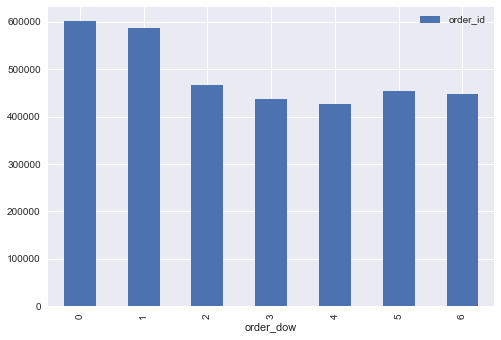

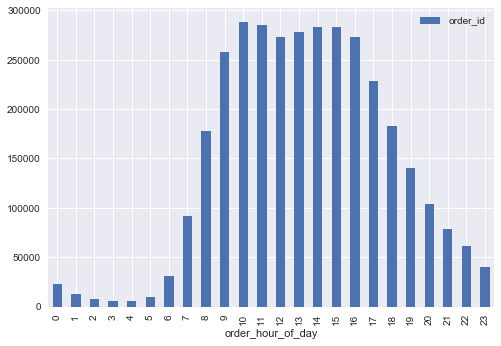

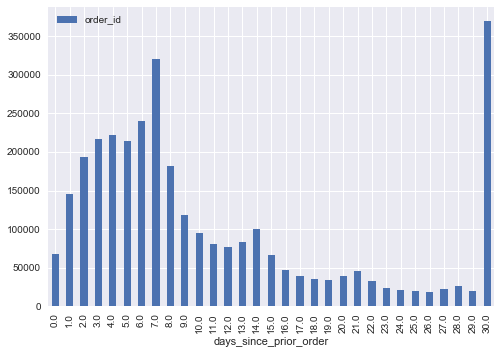

In [10]:
#### Gráficas

orders_by_dow.plot(kind='bar')
orders_by_hour.plot(kind='bar')
orders_since_prior.plot(kind='bar')

plt.show()

In [11]:
#### Cuántos productos compra la gente?
## Prior
n_products_prior = dfOrderPrior[['order_id','product_id']].groupby('order_id').count()
n_products_prior = n_products_prior.sort_index()
n_products_prior['order'] = n_products_prior.index
n_products_prior = n_products_prior.groupby('product_id').count()

n_products_prior.plot(kind='bar')

## Train
n_products_train = dfOrderTrain[['order_id','product_id']].groupby('order_id').count()
n_products_train = n_products_train.sort_index()
n_products_train['order'] = n_products_train.index
n_products_train = n_products_train.groupby('product_id').count()

n_products_train.plot(kind='bar')


#### Mejores productos venta (Train)
best_products = dfOrderTrain[['order_id','product_id']].groupby('product_id').count()
best_products = best_products.sort_values(by=['order_id'],ascending=False)
best_products['product'] = best_products.index
best_products = best_products.rename(columns={'order_id':'order_count'})
best_products = pd.merge(best_products,dfProducts,how='left',left_on='product',right_on='product_id')

#### Productos reordenados
reordered = dfOrderTrain['reordered'].value_counts()
reordered.plot(kind='bar')

#### MMás frecuentes reordenados
often_reorder = dfOrderTrain[['order_id','product_id','reordered']].groupby('product_id').agg({'order_id':'count','reordered':'mean'}).rename(columns={'order_id':'order_count','reordered':'reorder_proportion'})
often_reorder = often_reorder.sort_values(by=['reorder_proportion'],ascending=[False])
often_reorder = pd.merge(often_reorder,dfProducts, how='left', left_on=often_reorder.index.values,right_on='product_id')
print (often_reorder[often_reorder['order_count'] > 30].head(20))

      order_count  reorder_proportion  product_id  \
4126           92            0.934783        1729   
4152           35            0.914286       30630   
4153          368            0.913043       20940   
4175           59            0.898305       12193   
4190           45            0.888889       31764   
4192           81            0.888889       21038   
4212           35            0.885714       48927   
4215        18726            0.884172       24852   
4216          120            0.883333         117   
4219          483            0.881988       39180   
4220          269            0.881041       12384   
4221          461            0.878525       24024   
4222           81            0.876543       36717   
4223         1206            0.875622       38689   
4234           32            0.875000       14446   
4270           32            0.875000       15981   
4285           79            0.873418        9810   
4286          125            0.872000        5

    product_id  add_to_cart_order  product_count       pct  \
0        45004                  1             39  0.661017   
1        11885                  1             41  0.594203   
2        13128                  1             12  0.571429   
3         4100                  1             14  0.560000   
4         1729                  1             48  0.521739   
5         6729                  1             35  0.486111   
6         9285                  1             13  0.481481   
7         6848                  1             12  0.461538   
8        12640                  1             12  0.461538   
9        26405                  1             47  0.447619   
10       13948                  1             27  0.442623   
11       21883                  1             11  0.440000   
12        4731                  1             22  0.431373   
13       26900                  1             24  0.428571   
14       40939                  1            145  0.423977   
15      

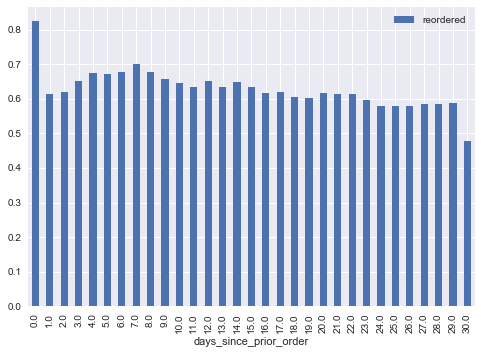

In [15]:
#### Artículos agregados primero al carrito
added_first = dfOrderTrain
added_first = added_first[['product_id','add_to_cart_order']].groupby(['product_id','add_to_cart_order']).agg({'product_id':'count'}).rename(columns={'product_id':'product_count'})
added_first['pct'] = added_first.groupby(level=0).apply(lambda x: x/float(x.sum()))
added_first = added_first.reset_index(level=['product_id','add_to_cart_order'])
added_first = added_first[added_first['add_to_cart_order']==1]
added_first = added_first[added_first['product_count'] > 10].sort_values(by=['pct'],ascending=[False])
added_first = pd.merge(added_first,dfProducts,how='left',on='product_id')
print (added_first.head(20))

#### Asociacón entre el tiempo de la úlitma orden y probabilidad de reorden

reorder_assoc = pd.merge(dfOrder[['order_id','days_since_prior_order']],dfOrderTrain,how='left',on='order_id')
reorder_assoc = reorder_assoc.dropna(subset=['product_id','days_since_prior_order'])
reorder_assoc = reorder_assoc[['days_since_prior_order','reordered']].groupby('days_since_prior_order').mean()
reorder_assoc.plot(kind='bar')
plt.show()
